In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
sns.set()
from results import load

#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}
experiment_phase_labels = [*experiment_phase]

# Reading the results

In [2]:
#config
experiment_name = "full"
providers = ["aws","ibm","gcf","azure"] 
num_repetitions = 1
configs = [ "0,0,1","0,0,0.5","0,0,2","60,60,0.5","60,60,1"]

all = pd.read_csv("results/full.csv")#load(experiment_name, providers,configs,num_repetitions,True)
all.columns

Index(['Unnamed: 0', 'RId', 'WL', 'CId', 'CStart', 'ELat', 'RSuccess', 'Phase',
       'RStart', 'EStart', 'EEnd', 'REnd', 'CPlat', 'COs', 'RInput',
       'Provider', 'RLat', 'RResult', 'run', 'sourceFile', 'RCode', 'HId'],
      dtype='object')

In [ ]:

def plotLatencyBand(ax,data,group,lat,label="Latency",interval=1000):
    g = group+"_"+lat+"_"+str(interval)
    data[g] = round(data[group]/interval)
    lats = data.groupby([g])[lat].agg([np.mean,np.max,np.min]).reset_index()
    sns.lineplot(x=g, y='mean', data=lats,ax=ax,label=label)
    ax.fill_between(x=g,y1="amax",y2="amin",data=lats,alpha=0.5)

    
def plotWorkload(ax,data,time,label="Workload",interval=1000):
    g = time+"_WL_"+str(interval)
    data[g] = round(data[time]/interval)
    lats = data.groupby([g])['RId'].count().reset_index(name="workload")
    sns.lineplot(x=g, y='workload', data=lats, color="gray",label=label,ax=ax2)    



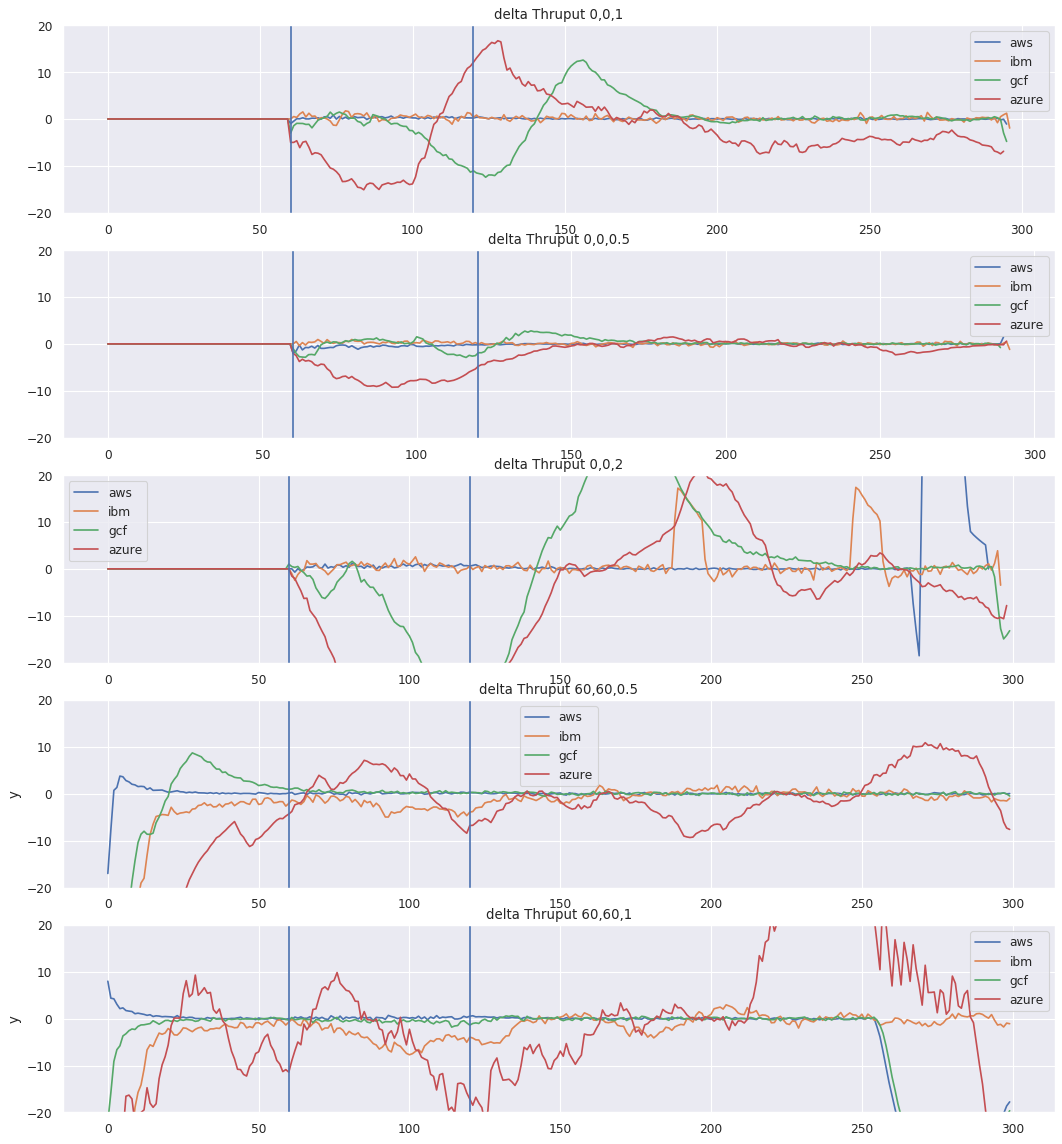

In [86]:
#prep data
data = all.copy()

data['RStart_1s'] = round(data["RStart"]/1000)
data['REnd_1s'] = round(data["REnd"]/1000)

data = data[data["Phase"].isin(["p0","p1","p2"])]
#preselect
fig,axs = plt.subplots(5,figsize=(16,18), dpi= 80)
idx = 0
for workload in configs:
    ax = axs[idx]
    for provider in providers:
        ax.set_title("delta Thruput {}".format(workload))
        tmp = data[(data["Provider"]==provider)&(data["WL"]==workload)]
        started_requests = tmp.groupby("RStart_1s")["RId"].count().reset_index(name="y")
        started_requests = started_requests["y"].ewm(span=30)
        #started_requests.mean().plot(style = 'tab:red')


        finished_requests = tmp.groupby("REnd_1s")["RId"].count().reset_index(name="y")
        finished_requests = finished_requests["y"].ewm(span=30)
        delta_thr = (finished_requests.mean()-started_requests.mean())
        if workload[0] == "0":
            delta_thr = np.pad(delta_thr,(60,0),'constant')
        delta_thr = delta_thr[0:300]
        sns.lineplot(y=delta_thr,x=range(0,len(delta_thr)),ax=ax,label=provider)
    ax.axvline(60)
    ax.axvline(120)
    ax.set_ylim([-20,20])
    ax.legend()
    idx+=1

#plt.plot("RStart_1s","y",data=started_requests,color="tab:red")
# tmp = data[(data["Provider"]==provider)&(data["WL"]==workload)]
# finished_requests = tmp.groupby("REnd_1s")["RId"].count().reset_index(name="y")



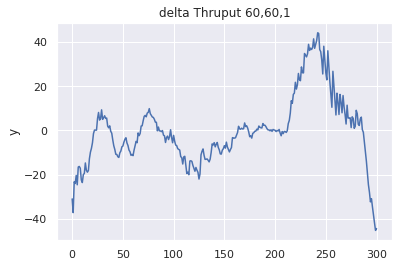

In [72]:
fig,ax = plt.subplots()
plt.title("delta Thruput {}".format(workload))
tmp = data[(data["Provider"]==provider)&(data["WL"]==workload)]
started_requests = tmp.groupby("RStart_1s")["RId"].count().reset_index(name="y")
started_requests = started_requests["y"].ewm(span=30)
#started_requests.mean().plot(style = 'tab:red')


finished_requests = tmp.groupby("REnd_1s")["RId"].count().reset_index(name="y")
finished_requests = finished_requests["y"].ewm(span=30)
delta_thr = (finished_requests.mean()-started_requests.mean())
sns.lineplot(y=delta_thr,x=range(0,len(delta_thr)),ax=ax)

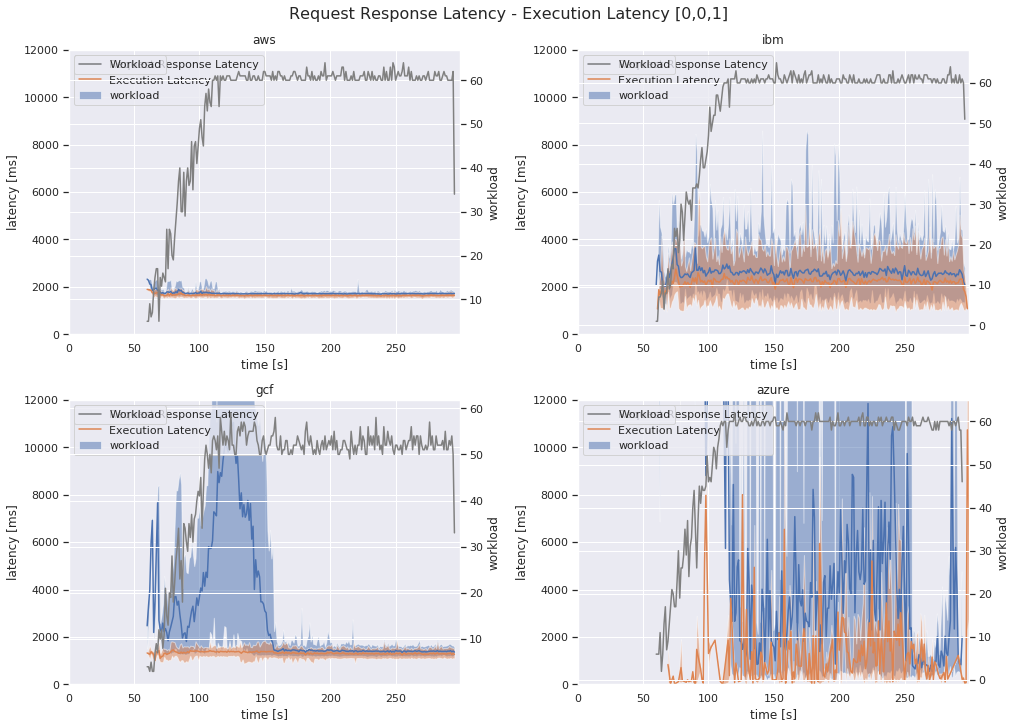

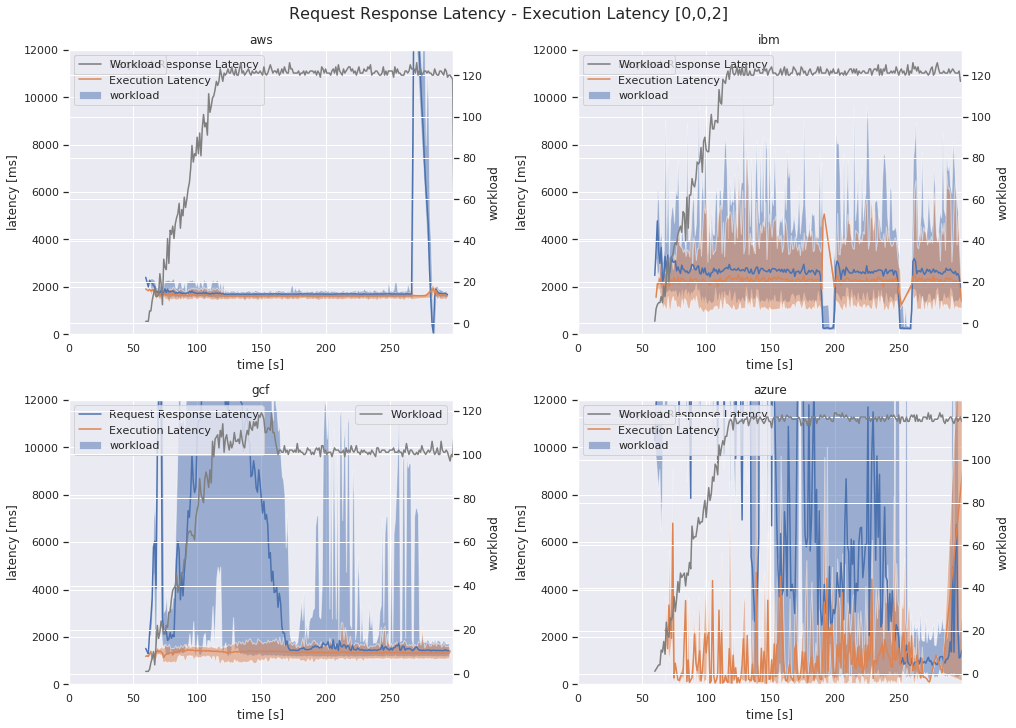

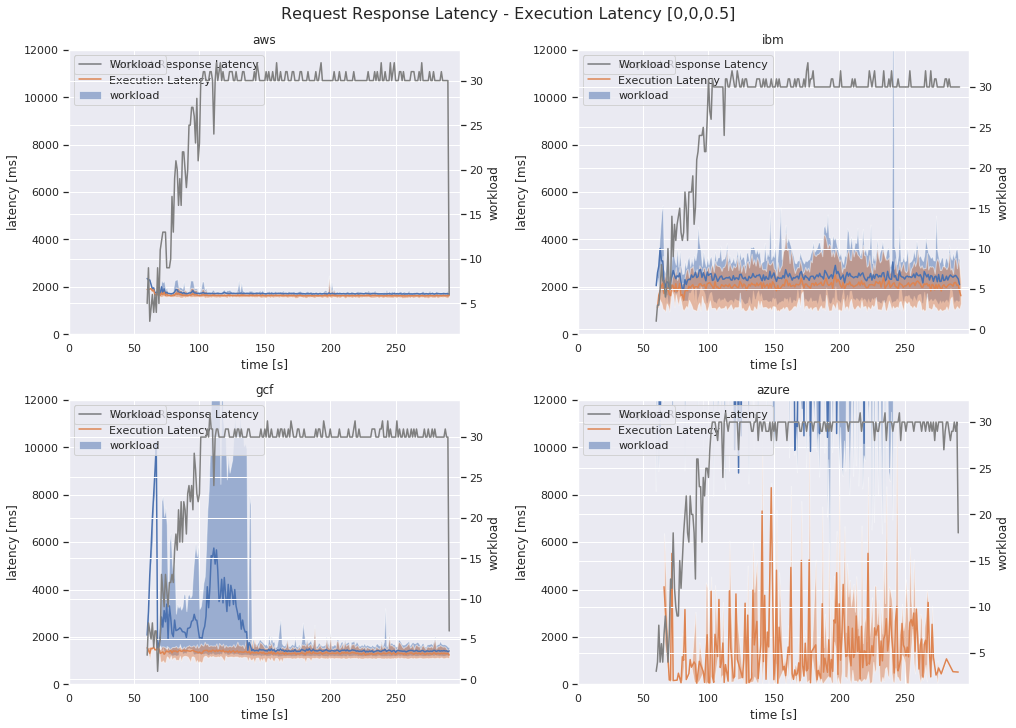

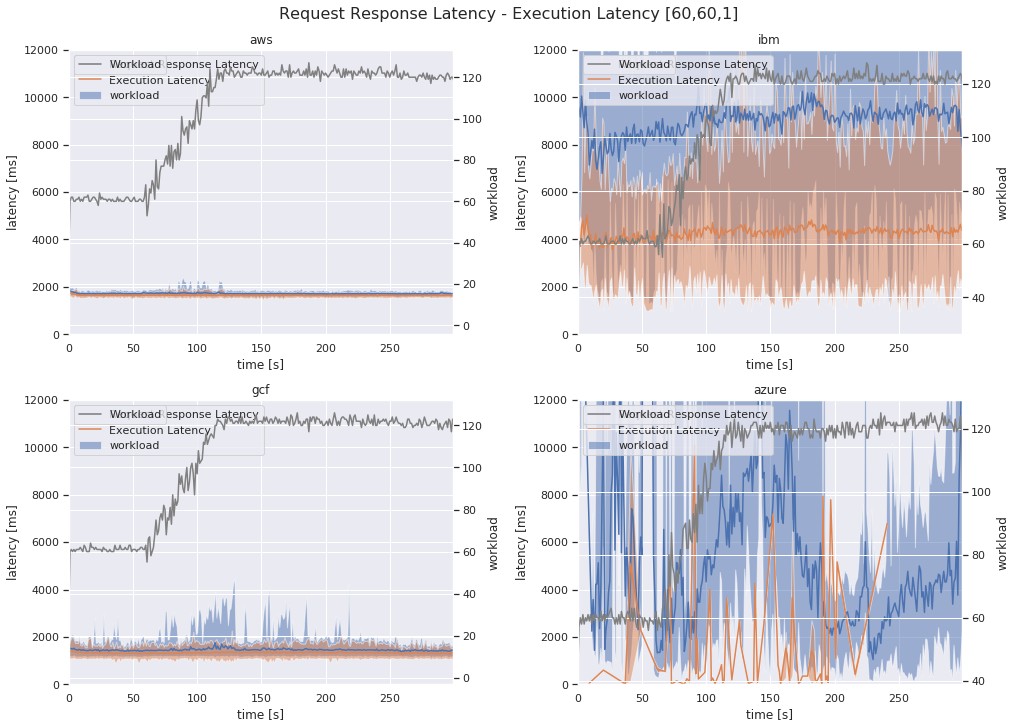

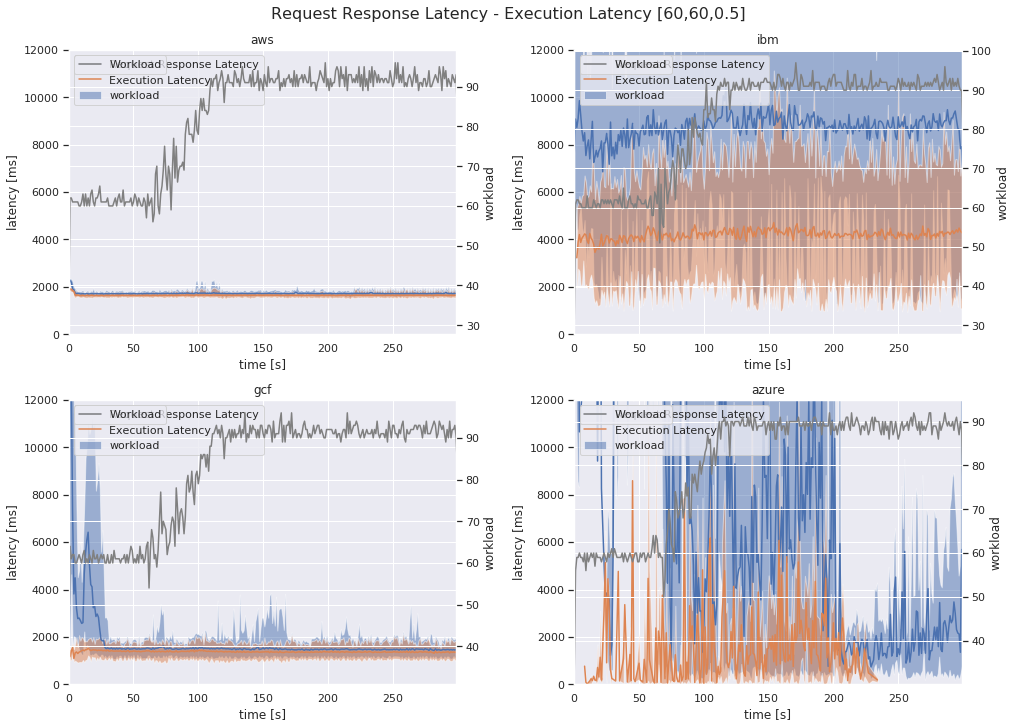

In [6]:
run = 1
workloads = all['WL'].unique()
providers = all['Provider'].unique()
from matplotlib.gridspec import GridSpec

positions = {"aws":(0,0),"gcf":(1,0),"ibm":(0,1),"azure":(1,1)}

for WL in workloads:
    fig = plt.figure(constrained_layout=True,figsize=(14,10))
    gs = GridSpec(2, 2, figure=fig)
    plt.suptitle("Request Response Latency - Execution Latency [%s]"%(WL), fontsize=16)
    idx=0
    for provider in providers:
        data = all[(all['WL'] == WL) & (all['Provider'] == provider) & (all['run'] == run)]
        data = data.copy()
        pos = positions[provider]
        ax = fig.add_subplot(gs[pos[0], pos[1]])
        plotLatencyBand(ax,data,'RStart','RLat',"Request Response Latency")
        plotLatencyBand(ax,data,'EStart','ELat',"Exectution Latency")
        ax2 = ax.twinx()
        plotWorkload(ax2,data,'RStart')
        
        ax.set_xlabel("time [s]")
        ax.set_ylabel("latency [ms]")
        ax.set_title(provider)
        ax.legend(["Request Response Latency", "Execution Latency","workload"], loc='upper left')
        ax.set_xlim([0,299])
        ax.set_ylim([0,12000])
        idx+=1

    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
